## Домашнее задание №3

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

## Задача №1:
В этом задании мы будем решать задачу классификации картинок датасета CIFAR на 10 классов.



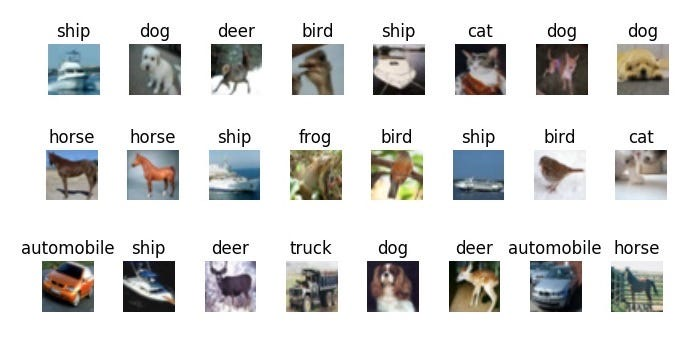

Ваша задача — построить нейросеть для классификации картинок CIFAR и добиться качества классификации > 0.5. За основу можно брать код из ноутбука [третьего занятия](https://colab.research.google.com/drive/1Xx7vfWttf6FabC7OVZOhg63F3CW3RdkI?usp=sharing).

В качестве решения в Я.Контест нужно будет отправить обученную модель. Код обучения модели и получения файла для отправки в Я.Контест реализованы ниже. Баллы выставляются следующим образом:
- 0, если ваша модель получает accuracy < 0.5 на тестовой выборке;
- 1, если ваша модель получает accuracy > 0.5 на тестовой выборке;

Код для проверки качества модели на тестовой выборке есть ниже. Пожалуйста, перед отправкой решения в контест, убедитесь, что ваша модель получает нужное значение accuracy на тестовой выборке.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

### Загрузка данных

Код для загрузки данных полностью реализован, ничего изменять не нужно.

CIFAR10 — это датасет цветных картинок, поделенных на 10 классов. Среди картинок — изображения машин, самолетов, животных.

In [2]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

# разделим тренировочную выборку на train и val
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# заведем даталоадеры
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


Посмотрим на несколько картинок, чтобы понять, с чем мы имеем дело. Для отрисовки десяти картинок тренировочного сета запустите ячейку ниже:

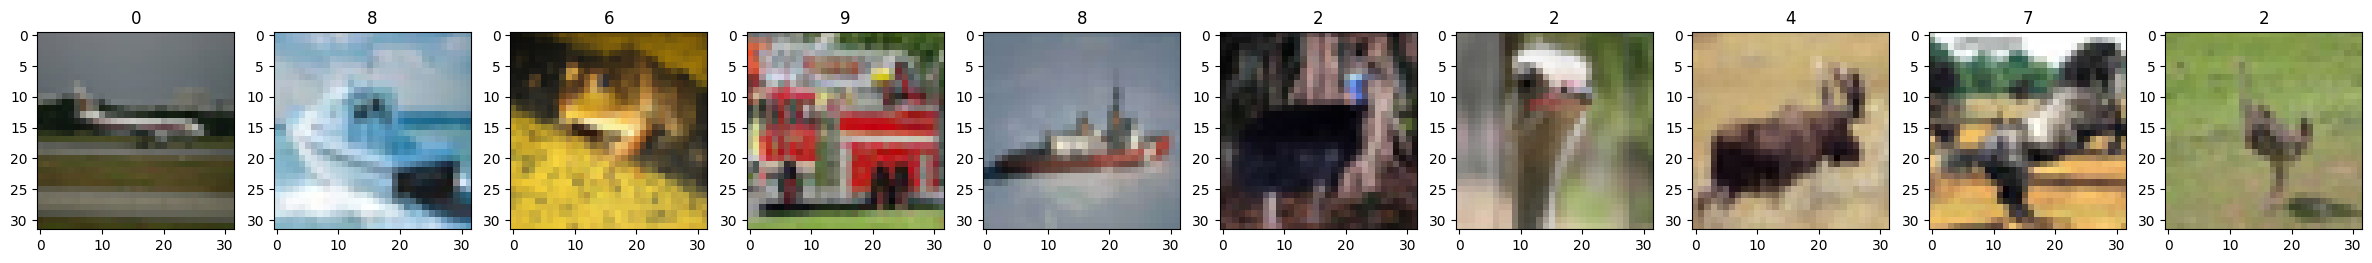

In [3]:
# эта функция отрисовывает несколько картинок
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# получаем батч картинок из train даталоадера
for batch in train_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

# вызываем функцию отрисовки картинок
show_images(images, labels)

Над каждой картинкой здесь написан номер класса, к которому она принадлежит.

Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      |
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Посмотрим, какого размера картинки:

In [4]:
images.shape

torch.Size([64, 3, 32, 32])

Здесь 64 — размер батча, 3 — количество цветовых каналов (т.к. картинка цветная, RGB) 32 и 32 — ширина и высота картинки.

Получается, каждая картинка представляется 32 * 32 * 3 = 3072 значениями. И в первом слое сети должно быть 3072 нейрона.

### Построение модели

Ваша задача — построить модель, и затем ее обучить. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить хорошее качество на тестовой выборке.

За основу можно взять код модели из ноутбука третьего занятия.
Не забудьте, что количество нейронов первого слоя должно быть другим, не таким, как на занятии.

**Что можно попробовать, чтобы улучшить качество модели:**
- добавить больше скрытых слоев;
- сделать больше нейронов в слоях;
- добавить слои batchnorm.

Слой батчнрм – BatchNorm1d (он импортирован в следующей ячейке). Этот слой применяется после полносвязного слоя. Пример:

```
def __init__(self):
        ...
        self.fc = nn.Linear(500, 100)
        self.bn = BatchNorm1d(100)
        ...

def forward(self, x):
        ...
        x = F.relu(self.fc(x))
        x = self.bn(x)
        ...
```

Попробуйте вставить слой BatchNorm после каждого слоя сети (кроме последнего).

Для успешной сдачи задания должно быть достаточно реализовать сеть с тремя слоями и BatchNorm между ними.
    

In [69]:
# импортируем BatchNorm
from torch.nn.modules.batchnorm import BatchNorm1d

# Реализуйте модель.

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.bn1 = BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn1(x)
        x = self.fc3(x)
        return x

Убедимся, что подключен GPU:

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
device

device(type='cuda')

In [71]:
# объявляем модель и переносим ее на GPU
model = Model().to(device)

В ячейке ниже — тесты для проверки вашей модели. Если ячейка не выдает ошибки, то модель работает правильно.

In [72]:
assert model is not None, 'Переменная model пустая. Где же тогда ваша модель?'

try:
    x = images.reshape(-1, 3072).to(device)
    y = labels

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('С моделью что-то не так')
    raise e


assert y_predicted.shape[-1] == 10, 'В последнем слое модели неверное количество нейронов'


### Обучение модели

Теперь нужно обучить модель. Воспользуемся тем же кодом с семинарского ноутбука. Опять же, за основу можно брать код из [третьего занятия](https://colab.research.google.com/drive/1wADBJAdbWbKEoZAmp0Tb-P5sqDKfIRa-?usp=sharing). Код для оценки качества модели (функция evaluate) уже реализована, она такая же, как в ноутбуке [третьего занятия](https://colab.research.google.com/drive/1wADBJAdbWbKEoZAmp0Tb-P5sqDKfIRa-?usp=sharing).

In [73]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn):

    y_pred_list = []
    y_true_list = []
    losses = []

    # проходимся по батчам даталоадера
    for i, batch in enumerate(tqdm(dataloader)):

        # так получаем текущий батч
        X_batch, y_batch = batch

        # выключаем подсчет любых градиентов
        with torch.no_grad():

            # получаем ответы сети на батч
            logits = model(X_batch.to(device))

            # вычисляем значение лосс-функции на батче
            loss = loss_fn(logits, y_batch.to(device))
            loss = loss.item()

            # сохраняем лосс на текущем батче в массив
            losses.append(loss)

            # для каждого элемента батча понимаем,
            # к какому классу от 0 до 9 отнесла его сеть
            y_pred = torch.argmax(logits, dim=1)

        # сохраняем в массивы правильные ответы на текущий батч
        # и ответы сети на текущий батч
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    # считаем accuracy между ответам сети и правильными ответами
    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

In [74]:
def train(model, loss_fn, optimizer, n_epoch=6):

    model.train(True)

    data = {
        'acc_train': [],
        'loss_train': [],
        'acc_val': [],
        'loss_val': []
    }

    # цикл обучения сети
    for epoch in tqdm(range(n_epoch)):

        for i, batch in enumerate(tqdm(train_loader)):

            # так получаем текущий батч картинок и ответов к ним
            X_batch, y_batch = batch

            # forward pass (получение ответов сети на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            optimizer.zero_grad() # обнуляем значения градиентов оптимизаторв
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети

        # конец эпохи, валидируем модель
        print('On epoch end', epoch)

        acc_train_epoch, loss_train_epoch = evaluate(model, train_loader, loss_fn)
        print('Train acc:', acc_train_epoch, 'Train loss:', loss_train_epoch)

        acc_val_epoch, loss_val_epoch = evaluate(model, val_loader, loss_fn)
        print('Val acc:', acc_val_epoch, 'Val loss:', loss_val_epoch)


        data['acc_train'].append(acc_train_epoch)
        data['loss_train'].append(loss_train_epoch)
        data['acc_val'].append(acc_val_epoch)
        data['loss_val'].append(loss_val_epoch)

    return model, data

In [75]:
# объявляем модель и переносим ее на GPU
model = Model().to(device)

# функция потерь
loss_fn = torch.nn.CrossEntropyLoss()

# оптимизатор
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [76]:
model, data = train(model, loss_fn, optimizer, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 0


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.42135 Train loss: 1.61897928314209


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4003 Val loss: 1.6682785058477123


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 1


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.469425 Train loss: 1.4973692529678344


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4423 Val loss: 1.5714390293048446


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 2


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.491475 Train loss: 1.4328834981918335


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.456 Val loss: 1.5322443284806173


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 3


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.505575 Train loss: 1.39434624376297


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4685 Val loss: 1.5201940817438113


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 4


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.530525 Train loss: 1.3187755482673644


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4784 Val loss: 1.4710547468464845


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 5


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.550125 Train loss: 1.2761329298019408


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4996 Val loss: 1.4440323904061774


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 6


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.56365 Train loss: 1.2348771334648132


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5002 Val loss: 1.4331838522747065


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 7


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.56815 Train loss: 1.2174987004280091


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4955 Val loss: 1.4328218182181096


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 8


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.579375 Train loss: 1.189844749736786


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5007 Val loss: 1.4298501234904977


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 9


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.585825 Train loss: 1.1707407972335815


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5027 Val loss: 1.42696195043576


### Оценка качества на тестовой выборке

Оценим качество модели на тестовой выборке:

In [77]:
test_acc, test_loss = evaluate(model, test_loader, loss_fn)

  0%|          | 0/157 [00:00<?, ?it/s]

In [78]:
test_acc

0.503

Проверка, что необходимые пороги пройдены:

In [79]:
assert test_acc >= 0.5, 'Accuracy на тесте >0.5! Можно сдавать задание'

### Сдача задания
В ячейке ниже реализован код для получения файла с обученной сетью. Запустите эти ячейки. Полученный файл model.pt отправьте в Я.Контест


In [80]:
x = torch.randn((64, 32*32*3))
torch.jit.save(torch.jit.trace(model.cpu(), (x)), "model.pth")

Теперь у вас во вкладке "файлы" лежит файл model.pth. Загрузите этот файл в Я.Контест. И на этом задание завершено. Поздравляем!



1. В чём отличие стохастического (SGD) и классического (GD) алгоритмов градиентного спуска. Укажите все верные варианты ответов:

    Одна итерация алгоритма SGD выполняется в среднем быстрее, чем одна итерация алгоритма GD.
    Одна итерация алгоритма SGD выполняется в среднем дольше, чем одна итерация алгоритма GD.
    Общее число итераций для алгоритма SGD больше, чем в GD.
    Общее число итераций для алгоритма SGD меньше, чем в GD.
    Оба метода могут быть использованы для обучения моделей на разных объёмах данных, но выбор между ними зависит от конкретных требований к модели и доступных ресурсов.

Одна итерация алгоритма SGD выполняется в среднем быстрее, чем одна итерация алгоритма GD.
Общее число итераций для алгоритма SGD больше, чем в GD.
Оба метода могут быть использованы для обучения моделей на разных объёмах данных, но выбор между ними зависит от конкретных требований к модели и доступных ресурсов.

2. При градиентном спуске по мини-батчам количество элементов в батче:
Одинаковое на каждой итерации одной эпохи и меняется от эпохи к эпохе.
Разное на каждой итерации алгоритма.
Одинаковое на всем протяжении алгоритма.
Размер батча не влияет на качество обученного алгоритма.
Размер батча влияет на качество обученного алгоритма
Оптимальный размер батча зависит от задачи и входных данных.

Одинаковое на всем протяжении алгоритма.
Размер батча влияет на качество обученного алгоритма
Оптимальный размер батча зависит от задачи и входных данных.

3. В чём суть стандартизации данных?
Сделать так, чтобы значения всех признаков находились в отрезке [0, 1].
Приведение среднего значения всех признаков в данных к 0 и дисперсии к 0.
Приведение среднего значения всех признаков в данных к 1 и дисперсии к 0.
Приведение среднего значения всех признаков в данных к 0 и дисперсии к 1.

In [ ]:
# Приведение среднего значения всех признаков в данных к 0 и дисперсии к 1.

4. Слой BatchNorm позволяет сделать обучение сети (выберите все верные варианты):

    Более стабильным.
    Слой BatchNorm ухудшает стабильность обучения.
    Часто позволяет получить лучшее качество сети для задачи.
    Слой BatchNorm никогда не улучшает качество модели.

In [ ]:
# Более стабильным. 
# Часто позволяет получить лучшее качество сети для задачи.

5. В чем заключается эффект internal covariate shift?
В изменении распределений входных данных в процессе обучения сети.
В изменении распределений выходов последнего слоя сети в процессе обучения сети.
В изменении распределений выходов промежуточных слоев сети в процессе обучения сети.
В изменении распределений весов промежуточных слоев сети в процессе обучения сети.

In [ ]:
# В изменении распределений выходов промежуточных слоев сети в процессе обучения сети.

6. Укажите основные функции валидационной выборки, рассмотренные на лекции:

    Отслеживание качества модели в процессе её обучения.
    Подбор обучаемых параметров.
    Подбор некоторых гиперпараметров.
    Ускорение скорости работы процесса обучения.

In [4]:
# Отслеживание качества модели в процессе её обучения.
# Подбор некоторых гиперпараметров.

7. Укажите основные параметры torch.utils.data.DataLoader, рассмотренные на лекции:

    Набор данных.
    Размер батча.
    Необходимость перемешивания данных перед каждой эпохой для разделения на батчи.

In [ ]:
# Набор данных.
# Размер батча.
# Необходимость перемешивания данных перед каждой эпохой для разделения на батчи.

8. Предположим, мы решаем задачу классификации изображений. Для каких частей обязательно нужно перемешивать элементы данных перед каждой эпохой?

    Для тестовой
    Для валидационной
    Для тренировочной

In [ ]:
# Для тренировочной

9. Сколько нейронов должно быть в первом (входном) слое полносвязной сети, которая принимает на вход черно-белую картинку размера 10x20?
10.
20.
30.
200.
Сколько угодно.

In [ ]:
# 200

10. Пусть мы пишем нейросеть - класс SimpleNet для классификации черно-белых картинок размера 10x15 на шесть классов. Что нужно поставить вместо трёх знаков вопроса в коде ниже, чтобы сеть работала правильно?

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(?, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(?, ?)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

10, 64, 6
15, 64, 6
150, 64, 6
150, любое число, 6
10, любое число, 6
15, любое число, 6
Любое число, 64, 6
Любое число, любое число, 6
Все значения могут быть любыми целыми числами.

In [ ]:
# 150,64,6